In [1]:
!python -V

Python 3.9.13


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [36]:
import pickle

In [3]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df['duration'] = (df.lpep_dropoff_datetime - df.lpep_pickup_datetime).apply(lambda td: td.total_seconds() / 60)
    #df = df[df.trip_type == 2]
    df = df[((df.duration >= 1) & (df.duration <= 60))]
    
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [4]:
df_train = read_dataframe('./data/green_tripdata_2022-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2022-02.parquet')

In [5]:
len(df_train),len(df_val)

(59603, 66097)

In [6]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [10]:
categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical+numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical+numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [11]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [38]:
lr = LinearRegression()
#lr = Lasso(alpha=0.0001)
lr.fit(X_train,y_train)

y_pred = lr.predict(X_val)

# wrong on average by root mean square error min
mean_squared_error(y_val,y_pred, squared=False)

6.9013967947650965

In [40]:
with open('models/lin_reg.bin','wb') as f_out:
    pickle.dump((dv,lr), f_out)

In [33]:
len(y_train), len(y_val)

(59603, 66097)

In [34]:
df_val.duration.describe(percentiles=[0.95,0.98,0.99])

count    66097.000000
mean        14.819980
std          9.963805
min          1.000000
50%         12.216667
95%         35.216667
98%         44.000000
99%         49.834000
max         60.000000
Name: duration, dtype: float64

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


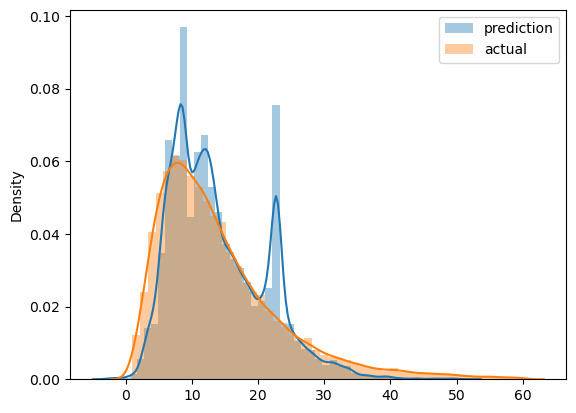

In [35]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()